# Shor's Algorithm (by Gerard Leyva)

This is the Shor's algorithm for $N=63$. This script is based from the Qiskit tutorial with several changes.

https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb

The supported values of $a$ are $a=\{2,63\}$. This Jupyter notebook can is divided into five sections, listed in the end of this cell as a table of contents.

# Tutorial
This script can be simply be ran in its entirety, which will execute section 5 (Execute Shor's Algorithm) and the circuit details provided in section 4 (Circuit Analysis). Note that section 5.c will run code that will run Shor's algorithm multiple times and save the results as ShorN63.csv.

The main portion that everybody will want to see (at first) is Shor's Algorithm finding a non-trivial factor of 63. To do this, make sure that section 3 section (Code Implementation Section) is executed in its entirety. Then run section 5.a (Find one factor, then stop).

Section 5.b will run the algorithm multiple times until it finds the two factors (9 and 7) of 63. It will also provide measurements of time based on the attempts it tries. Section 5.c does 5.c $S$ times, which is incredibly useful to get a sample set.

# Table of contents
## 1. Configuration Section
## 2. Circuit Design Section
## 3. Code Implementation Section
### c_amodN(): $U$ implementation
### qft_dagger(): Inverse quantum Fourier transform
### qpe_amodN(a): Quantum phase estimation function
## 4. Circuit Analysis
### The Quantum Circuit Schematic
### 4.b: Measure the circuit depth details
### 4.c: Output registers and phases
## 5. Execute Shor's Algorithm
### 5.a: Find one factor, then stop
### 5.b: Don't stop the script until the answer is complete
### 5.c: Completely factor $S$ times

## 1. Configuration Section
This section simply loads all the Python modules and a couple of global variables that are used throughout the notebook.

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

import qiskit.quantum_info as qi # Matrices, vectors, etc.

from qiskit.circuit.library import QFT

print("Imports Successful")

# Global parameters
N = 63
a = 2               # Fixed value for a. Some scripts have I made have a very limited range for a.
ancilla_qubits = 6  # Minimum number of qubits needed to carry the operation
n_count = 8         # Number of counting qubits. This is set to 8 because we (our team in the QC course) did factoring for
                    # N = 511 (11111111, i.e. 2^8 [qu]bits), so this was necessary to set it 8 in order to analyze our
                    # findings throughout N = {15,21,63,255,511} consistent.

Imports Successful


## 2. Circuit Design Section
This section provides the basis for designing the c_amod() function, which is the funciton responsible for the modulus operation:

$$U|y\rangle = |ay\bmod 63\rangle $$

This c_amod() function performs what the $U$ matrix does to the wave function $|y\rangle$ that is fundamental in order to execute Shor's Algorithm for $N=63$. Because $63\in 2^n -1$ (that is, 111111 in binary is 63 in base-10) and is not a prime number, the periodicity of $U$ can be observed as a series of swaps:
$$U|000001\rangle = |000010\rangle$$
$$U|000010\rangle = |000100\rangle$$
$$U|000100\rangle = |001000\rangle$$
$$U|001000\rangle = |010000\rangle$$
$$U|010000\rangle = |100000\rangle$$
$$U|100000\rangle = |000001\rangle$$
For this circuit, $a=2$ is fixed for the interests of our JHU course project schedules. The code below was used as a sandbox to 
see if $|000001\rangle$ does indeed change to $|000010\rangle$ upon $U|000001\rangle$.

In [59]:
# Run tests here to see if U|000001> = |desired qubit>
U = QuantumCircuit(6)

#The input qubit. Feel free to try any of the qubits listed above! e.g. for |000100>, use:
#U.x(2)
U.x(0)

U.barrier()
U.swap(4,5)
U.swap(3,4)
U.swap(2,3)
U.swap(1,2)
U.swap(0,1)
U.measure_all()
U.draw()
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(U, aer_sim)
#qobj = assemble(t_qc)
results = aer_sim.run(t_qc).result()
counts = results.get_counts()

# Print the result. For U.x(0) / |000001>, you should see:
#result = {'000010': 1024}
print("result =",counts)
U.draw()
#decomposed_circ = U.decompose() # Does not modify original circuit
#decomposed_circ.draw(fold=-1)

result = {'000010': 1024}


┌───┐ ░                 ░ ┌─┐               
   q_0: ┤ X ├─░──────────────X──░─┤M├───────────────
        └───┘ ░              │  ░ └╥┘┌─┐            
   q_1: ──────░───────────X──X──░──╫─┤M├────────────
              ░           │     ░  ║ └╥┘┌─┐         
   q_2: ──────░────────X──X─────░──╫──╫─┤M├─────────
              ░        │        ░  ║  ║ └╥┘┌─┐      
   q_3: ──────░─────X──X────────░──╫──╫──╫─┤M├──────
              ░     │           ░  ║  ║  ║ └╥┘┌─┐   
   q_4: ──────░──X──X───────────░──╫──╫──╫──╫─┤M├───
              ░  │              ░  ║  ║  ║  ║ └╥┘┌─┐
   q_5: ──────░──X──────────────░──╫──╫──╫──╫──╫─┤M├
              ░                 ░  ║  ║  ║  ║  ║ └╥┘
meas: 6/═══════════════════════════╩══╩══╩══╩══╩══╩═
                                   0  1  2  3  4  5

## 3. Code Implementation Section
Now we'll insert what we got from our Section 2 sandbox and insert into the c_amodN() function. Remember, this function is the fundamental operation that is used to implement Shor's Algorithm here.
### c_amodN(): $U$ implementation

In [60]:
def c_amodN(a, power):
    """Controlled multiplication by a mod N"""
    if a not in [2,61]:
        raise ValueError("'a' must be 2 or 61")
    U = QuantumCircuit(ancilla_qubits)
    for iteration in range(power):
        if a in [2,61]:
            U.swap(4,5)
            U.swap(3,4)
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
#        if a in [4,27]:
#            U.swap(3,4)
#            U.swap(2,4)
#            U.swap(1,3)
#            U.swap(0,2)
#        if a in [8,23]:
#            U.swap(3,4)
#            U.swap(2,3)
#            U.swap(1,4)
#            U.swap(0,3)
        if a in [61]:
            for q in range(ancilla_qubits):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod %i" % (a, power, N)
    c_U = U.control()
    return c_U

### qft_dagger(): Inverse quantum Fourier transform
This is the inverse quantum Fourier transform function (QFT Dagger) that is used in Shor's Algoithm. This is largely unchanged from https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb

In [61]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

### a2jmodN(a, j, N): Modular exponential function
This is the modular exponential function that will be needed in order to create $U^{2^j}$ gates so that the operation
$$U^{2^j} |y\rangle = |a^{2^j} y \bmod N\rangle,$$
grows polynomially with $j$. This code is unchanged from the [source]( https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb).

In [62]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a

### qpe_amodN(a): Quantum phase estimation function
This functions performs the quantum phaseestimation. While it's largely based off the [source](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb), it has been modified to fit agnostic values of $N$ and the number qubits (including ancillas).

In [63]:
def qpe_amodN(a):
    #n_count = 10
    qc = QuantumCircuit(ancilla_qubits+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(ancilla_qubits-1+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amodN(a, 2**q), 
                 [q] + [i+n_count for i in range(ancilla_qubits)])
    #qc.append(QFT(n_count).inverse(), range(n_count))
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT    
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, aer_sim)
    #qobj = assemble(t_qc, shots=1024)
    result = aer_sim.run(t_qc, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    time = result.time_taken
    return phase,time

## 4. Circuit Analysis
In this section, we create a circuit for the purposes of analyzing the circuit's circuit depth, the count of output registers and their corresponding phase measurements. This gives an idea as well as a picture and data of what is happening in this implementation of Shor's Algorithm.

### 4.a: The Quantum Circuit Schematic
Below, we prepare the circuit by placing all the input qubits in superpositions through Hadamard gates. Then, apply $U$ on each qubit, top to bottom.

In [64]:
# Create QuantumCircuit with n_count
qc = QuantumCircuit(n_count + ancilla_qubits, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(n_count)

# Do controlled-U operations
for q in range(n_count):
#for q in range(4):
    qc.barrier()
    qc.append(c_amodN(a, 2**q), 
             [q] + [i+n_count for i in range(ancilla_qubits)])

# Do inverse-QFT
qc.barrier()
qc.append(qft_dagger(n_count), range(n_count))
#qc.append(QFT(n_count).inverse(), range(n_count))  # Apply inverse QFT to the first register

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  # do not fold

#decomposed_circ = qc.decompose() # Does not modify original circuit
#decomposed_circ.draw(fold=-1)

┌───┐ ░                 ░                 ░                 ░                 ░                  ░                  ░                  ░                   ░ ┌───────┐┌─┐                     
 q_0: ┤ H ├─░────────■────────░─────────────────░─────────────────░─────────────────░──────────────────░──────────────────░──────────────────░───────────────────░─┤0      ├┤M├─────────────────────
      ├───┤ ░        │        ░                 ░                 ░                 ░                  ░                  ░                  ░                   ░ │       │└╥┘┌─┐                  
 q_1: ┤ H ├─░────────┼────────░────────■────────░─────────────────░─────────────────░──────────────────░──────────────────░──────────────────░───────────────────░─┤1      ├─╫─┤M├──────────────────
      ├───┤ ░        │        ░        │        ░                 ░                 ░                  ░                  ░                  ░                   ░ │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├─░────────┼────────░────────┼────────░────────■────────░─────────────────░──────────────────░──────────────────░──────────────────░───────────────────░─┤2      ├─╫──╫─┤M├───────────────
      ├───┤ ░        │        ░        │        ░        │        ░                 ░                  ░                  ░                  ░                   ░ │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├─░────────┼────────░────────┼────────░────────┼────────░────────■────────░──────────────────░──────────────────░──────────────────░───────────────────░─┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤ ░        │        ░        │        ░        │        ░        │        ░                  ░                  ░                  ░                   ░ │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├─░────────┼────────░────────┼────────░────────┼────────░────────┼────────░────────■─────────░──────────────────░──────────────────░───────────────────░─┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤ ░        │        ░        │        ░        │        ░        │        ░        │         ░                  ░                  ░                   ░ │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├─░────────┼────────░────────┼────────░────────┼────────░────────┼────────░────────┼─────────░────────■─────────░──────────────────░───────────────────░─┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤ ░        │        ░        │        ░        │        ░        │        ░        │         ░        │         ░                  ░                   ░ │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├─░────────┼────────░────────┼────────░────────┼────────░────────┼────────░────────┼─────────░────────┼─────────░────────■─────────░───────────────────░─┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤ ░        │        ░        │        ░        │        ░        │        ░        │         ░        │         ░        │         ░                   ░ │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├─░────────┼────────░────────┼────────░────────┼────────░────────┼────────░────────┼─────────░────────┼─────────░────────┼─────────░─────────■─────────░─┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤ ░ ┌──────┴──────┐ ░ ┌──────┴──────┐ ░ ┌──────┴──────┐ ░ ┌──────┴──────┐ ░ ┌──────┴───────┐ ░ ┌──────┴───────┐ ░ ┌──────┴───────┐ ░ ┌───────┴───────┐ ░ └───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ┤ X ├─░─┤0            ├─░─┤0            ├─░─┤0            ├─░─┤0            ├─░─┤0             ├─░─┤0             ├─░─┤0             ├─░─┤0              ├─░───────────╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘ ░ │             │ ░ │             │ ░ │             │ ░ │             │ ░ │              │ ░ │              │ ░ │              │ ░ │               │ ░           ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ──────░─┤1            ├─░─┤1            ├─░─┤1            ├─░─┤1            ├─░─┤1             ├─░─┤1             ├─░─┤1             ├─░─┤1              ├─░───────────╫──╫──╫──╫──╫──╫──╫──╫─
            ░ │             │ ░ │             │ ░ │             │ 

### 4.b: Measure the circuit depth details
This section provides the number of $U$ orperations, the number of operations of the decomposed gates (including the inverse-QFT gate), and a circuit diagram of the decomposed gates.

In [65]:
# Measure the circuit depth
print("Number of U operations:",qc.depth()-3)

decomposed_circ = qc.decompose() # Does not modify original circuit
print("Depth of circuit:",decomposed_circ.depth())
#decomposed_circ.draw(fold=-1)

Number of U operations: 8
Depth of circuit: 3843


### 4.c: Output registers and phases
Let's see what results we measure:

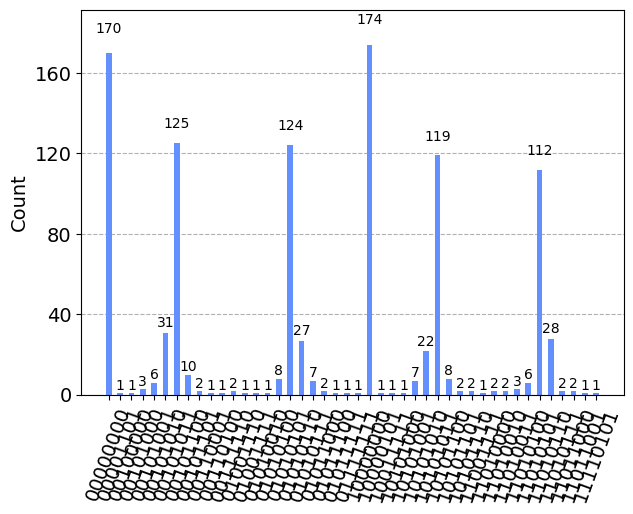

In [66]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
#qobj = assemble(t_qc)
results = aer_sim.run(t_qc).result()
counts = results.get_counts()
#filtered = {key: val for key,val in counts.items() if val > 99}
plot_histogram(counts)
#plot_histogram(filtered)

In [67]:
print(dict(sorted(counts.items())))

{'00000000': 170, '00001101': 1, '00100000': 1, '00101000': 3, '00101001': 6, '00101010': 31, '00101011': 125, '00101100': 10, '00101101': 2, '00110001': 1, '00110100': 1, '00111110': 2, '01001110': 1, '01001111': 1, '01010010': 1, '01010100': 8, '01010101': 124, '01010110': 27, '01010111': 7, '01011000': 2, '01011100': 1, '01011111': 1, '01111111': 1, '10000000': 174, '10000101': 1, '10011111': 1, '10101000': 1, '10101001': 7, '10101010': 22, '10101011': 119, '10101100': 8, '10101101': 2, '10101110': 2, '11001111': 1, '11010000': 2, '11010010': 2, '11010011': 3, '11010100': 6, '11010101': 112, '11010110': 28, '11010111': 2, '11011000': 2, '11011001': 1, '11110101': 1}


Corresponding measured phases.

In [68]:
rows, measured_phases = [], []
for output in counts:
#for output in filtered:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

             Register Output           Phase
0   00101011(bin) =  43(dec)   43/256 = 0.17
1   10000000(bin) = 128(dec)  128/256 = 0.50
2   01001110(bin) =  78(dec)   78/256 = 0.30
3   11010101(bin) = 213(dec)  213/256 = 0.83
4   10101011(bin) = 171(dec)  171/256 = 0.67
5   01010101(bin) =  85(dec)   85/256 = 0.33
6   10101001(bin) = 169(dec)  169/256 = 0.66
7   00000000(bin) =   0(dec)    0/256 = 0.00
8   00001101(bin) =  13(dec)   13/256 = 0.05
9   11010010(bin) = 210(dec)  210/256 = 0.82
10  11001111(bin) = 207(dec)  207/256 = 0.81
11  10101000(bin) = 168(dec)  168/256 = 0.66
12  00101010(bin) =  42(dec)   42/256 = 0.16
13  10101010(bin) = 170(dec)  170/256 = 0.66
14  00101000(bin) =  40(dec)   40/256 = 0.16
15  01011000(bin) =  88(dec)   88/256 = 0.34
16  01010110(bin) =  86(dec)   86/256 = 0.34
17  00100000(bin) =  32(dec)   32/256 = 0.12
18  01001111(bin) =  79(dec)   79/256 = 0.31
19  11010110(bin) = 214(dec)  214/256 = 0.84
20  11010011(bin) = 211(dec)  211/256 = 0.82
21  101011

We can now use the continued fractions algorithm to attempt to find $s$ and $r$ through the `fractions` module. This table is useful to see which phases provide even-numbered $r$ values.

In [69]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(N)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df.loc[(df['Guess for r'] % 2) == 0])  # filter our all the r's that are odd
print(df)

       Phase Fraction  Guess for r
0   0.167969      1/6            6
1   0.500000      1/2            2
3   0.832031      5/6            6
6   0.660156    33/50           50
11  0.656250    21/32           32
14  0.156250     5/32           32
15  0.343750    11/32           32
17  0.125000      1/8            8
22  0.843750    27/32           32
23  0.339844    17/50           50
30  0.519531    27/52           52
31  0.371094    23/62           62
35  0.847656    39/46           46
37  0.496094      1/2            2
38  0.812500    13/16           16
       Phase Fraction  Guess for r
0   0.167969      1/6            6
1   0.500000      1/2            2
2   0.304688     7/23           23
3   0.832031      5/6            6
4   0.667969      2/3            3
5   0.332031      1/3            3
6   0.660156    33/50           50
7   0.000000      0/1            1
8   0.050781     3/59           59
9   0.820312    32/39           39
10  0.808594    38/47           47
11  0.656250    21/3

## 5. Execute Shor's Algorithm
This is the main section where Shor's Algorithm is executed: factor $N$ through period finding. Here, we implement three approaches of recording data:

a. Find one factor, then stop (non-trivial, of course)

b. Find both factors, 9 and 7. That is, completely factor 63 such that 63 = 7 × 9. This will show various time measurements.

c. Execute b. $S$ succesful times. This will save the findings as ShorN63.csv.

### 5.a: Find one factor, then stop
This cell looks for one single non-trivial factor.

In [70]:
# Variables for all of section 5
factor_found = False
attempt = 0

#factor_store = 1
factor_count = 0

totaltime = 0
lowesttime = None

while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase, time = qpe_amodN(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: a = %i" % a) # Let's make sure that it's using a
    print("Result: r = %i" % r)

    print("Time taken:",time)
    #Record the time
    totaltime += time
    if lowesttime is None:
        lowesttime = time
    elif lowesttime > time:
        lowesttime = time
    
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                # 'product' will be checked the extracted guesses form a two-factor solution,
                # i.e. for 63 = 7 × 9
                product = guesses[0] * guesses[1]       
                print("*** Non-trivial factor found: %i ***" % guess)
                if factor_count == 0:
                    # Since the very first factor has been found, increase the count by one.
                    factor_count += 1
                elif (factor_count == 1) and (product == N):
                    # Another factor has been found and forms the two factor solution.
                    factor_count += 1
                elif (factor_count == 1) and (product != N):
                    # Another factor has been found but does not form the two factor solution,
                    # so just set it to 0 in order to skip the next if statement.
                    factor_count = 0
                if factor_count == 2:
                    twofactortime = time
                    print("Two-factor answer found: %i = %i × %i" % (N,guesses[0],guesses[1]))
                factor_found = True


Attempt 1:
Register Reading: 01010011
Corresponding Phase: 0.324219
Result: a = 2
Result: r = 37
Time taken: 0.24399709701538086
Guessed Factors: 63 and 1

Attempt 2:
Register Reading: 01010101
Corresponding Phase: 0.332031
Result: a = 2
Result: r = 3
Time taken: 0.22036337852478027
Guessed Factors: 1 and 3
*** Non-trivial factor found: 3 ***


### 5.b: Don't stop the script until the answer is complete
This repeats the loop for search until it is confirmed that $9 \times 7 = 63$.

In [71]:
if factor_count < 2:
    factor_found = False
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase, time = qpe_amodN(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    #r = 18 #for a = 2 provides the correct answer
    #r = 6 #for a = 2 provides the correct answer
    print("Result: a = %i" % a) # Let's make sure that it's using a
    print("Result: r = %i" % r)
    print("Time taken:",time)
    #Record the time
    totaltime += time
    if lowesttime is None:
        lowesttime = time
    elif lowesttime > time:
        lowesttime = time

    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                # 'product' will be checked the extracted guesses form a two-factor solution,
                # i.e. for 63 = 7 × 9
                product = guesses[0] * guesses[1]
                print("*** Non-trivial factor found: %i ***" % guess)
                if factor_count == 0:
                    # Since the very first factor has been found, increase the count by one.
                    factor_count += 1
                elif (factor_count == 1) and (product == N):
                    # Another factor has been found and forms the two factor solution.
                    factor_count += 1
                elif (factor_count == 1) and (product != N):
                    # Another factor has been found but does not form the two factor solution,
                    # so just set it to 0 in order to restart the process.
                    factor_count = 0
                if factor_count == 2:
                    twofactortime = time
                    factor_found = True
        if factor_found == True:
            print("Two-factor answer found: %i = %i × %i" % (N,guesses[0],guesses[1]))



Attempt 3:
Register Reading: 01010100
Corresponding Phase: 0.328125
Result: a = 2
Result: r = 61
Time taken: 0.24299883842468262
Guessed Factors: 63 and 1

Attempt 4:
Register Reading: 10000000
Corresponding Phase: 0.500000
Result: a = 2
Result: r = 2
Time taken: 0.2429962158203125
Guessed Factors: 1 and 3
*** Non-trivial factor found: 3 ***

Attempt 5:
Register Reading: 11010101
Corresponding Phase: 0.832031
Result: a = 2
Result: r = 6
Time taken: 0.24599838256835938
Guessed Factors: 7 and 9
*** Non-trivial factor found: 7 ***
*** Non-trivial factor found: 9 ***
Two-factor answer found: 63 = 7 × 9


#### Time measurements
These are the times it took for the circuit to: find the complete answer, and the total amount of time it took to calculate to the complete answer.

In [72]:
print("Total number of attempts:",attempt)
print("Fastest answer runtime:",lowesttime)
print("Two-factor answer runtime:",twofactortime)
print("Total runtime to the two-factor answer:",totaltime)

Total number of attempts: 5
Fastest answer runtime: 0.22036337852478027
Two-factor answer runtime: 0.24599838256835938
Total runtime to the two-factor answer: 1.1963539123535156


### 5.c: Completely factor $S$ times
Keep running until the algorithm completely factors $S$. When it finds one complete factorization, it will display the message:

"Data set for id # recorded."

This section can take long time and it writes a file to ShorN63.csv.

In [73]:
# Set the sample size here:
S = 8

def runmult(runs):
    # Initalize the lists of times
    listattempt = []
    listlowesttime = []
    listtwofactortime = []
    listtotaltime = []
    
    for i in range(runs):
        factor_found = False
        attempt = 0

        #factor_store = 1
        factor_count = 0

        totaltime = 0
        lowesttime = None

        while not factor_found:
            attempt += 1
            print("\nAttempt %i:" % attempt)
            phase, time = qpe_amodN(a) # Phase = s/r
            frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
            r = frac.denominator
            #r = 18 #for a = 2 provides the correct answer
            #r = 6 #for a = 2 provides the correct answer
            print("Result: a = %i" % a) # Let's make sure that it's using a
            print("Result: r = %i" % r)
            print("Time taken:",time)
            #Record the time
            totaltime += time
            if lowesttime is None:
                lowesttime = time
            elif lowesttime > time:
                lowesttime = time

            if phase != 0:
                # Guesses for factors are gcd(x^{r/2} ±1 , 15)
                guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
                print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
                for guess in guesses:
                    if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                        # 'product' will be checked the extracted guesses form a two-factor solution,
                        # i.e. for 63 = 7 × 9
                        product = guesses[0] * guesses[1]
                        print("*** Non-trivial factor found: %i ***" % guess)
                        if factor_count == 0:
                            # Since the very first factor has been found, increase the count by one.
                            factor_count += 1
                        elif (factor_count == 1) and (product == N):
                            # Another factor has been found and forms the two factor solution.
                            factor_count += 1
                        elif (factor_count == 1) and (product != N):
                            # Another factor has been found but does not form the two factor solution,
                            # so just set it to 0 in order to restart the process.
                            factor_count = 0
                        if factor_count == 2:
                            twofactortime = time
                            factor_found = True
                if factor_found == True:
                    print("Two-factor answer found: %i = %i × %i" % (N,guesses[0],guesses[1]))

        # Record the results
        listattempt.append(attempt)
        listlowesttime.append(lowesttime)
        listtwofactortime.append(twofactortime)
        listtotaltime.append(totaltime)

        print("Data set for id",i,"recorded.")
        table = pd.DataFrame({'Attempts':listattempt,'Fastest time':listlowesttime,'Two-factor answer time':listtwofactortime,'Total time':listtotaltime})
        
    return table


In [74]:
import csv

data = runmult(S)

#df = pd.DataFrame(data)
#df = pd.melt(df, value_vars=df.columns)
print(data)
filename = "ShorN%i.csv"%(N)
data.to_csv(filename)
print("File written to:",filename)


Attempt 1:
Register Reading: 10101011
Corresponding Phase: 0.667969
Result: a = 2
Result: r = 3
Time taken: 0.2670013904571533
Guessed Factors: 1 and 3
*** Non-trivial factor found: 3 ***

Attempt 2:
Register Reading: 11010101
Corresponding Phase: 0.832031
Result: a = 2
Result: r = 6
Time taken: 0.26400113105773926
Guessed Factors: 7 and 9
*** Non-trivial factor found: 7 ***
*** Non-trivial factor found: 9 ***
Two-factor answer found: 63 = 7 × 9
Data set for id 0 recorded.

Attempt 1:
Register Reading: 01010101
Corresponding Phase: 0.332031
Result: a = 2
Result: r = 3
Time taken: 0.24300026893615723
Guessed Factors: 1 and 3
*** Non-trivial factor found: 3 ***

Attempt 2:
Register Reading: 00101011
Corresponding Phase: 0.167969
Result: a = 2
Result: r = 6
Time taken: 0.22700119018554688
Guessed Factors: 7 and 9
*** Non-trivial factor found: 7 ***
*** Non-trivial factor found: 9 ***
Two-factor answer found: 63 = 7 × 9
Data set for id 1 recorded.

Attempt 1:
Register Reading: 00000000
Co

Register Reading: 11010101
Corresponding Phase: 0.832031
Result: a = 2
Result: r = 6
Time taken: 0.29627275466918945
Guessed Factors: 7 and 9
*** Non-trivial factor found: 7 ***
*** Non-trivial factor found: 9 ***
Two-factor answer found: 63 = 7 × 9
Data set for id 7 recorded.
   Attempts  Fastest time  Two-factor answer time  Total time
0         2      0.264001                0.264001    0.531003
1         2      0.227001                0.227001    0.470001
2         7      0.219001                0.248000    1.641000
3         4      0.240360                0.263751    1.037114
4         8      0.235001                0.326003    2.164012
5         7      0.241001                0.267297    1.918540
6         7      0.267892                0.290263    2.005007
7         8      0.256923                0.296273    2.301783
File written to: ShorN63.csv


## $\infty$. References

0. Original basis for this file: https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb

1. Stephane Beauregard, _Circuit for Shor's algorithm using 2n+3 qubits,_ [arXiv:quant-ph/0205095](https://arxiv.org/abs/quant-ph/0205095)

2. M. Nielsen and I. Chuang, _Quantum Computation and Quantum Information,_ Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000). (Page 633)

In [75]:
import qiskit.tools.jupyter
%qiskit_version_table